### Import of necessary libraries and environment configuration

1. **Reproducibility**: Sets a fixed seed (`seed = 42`) for Python and TensorFlow.
2. **Environment Setup**: Configures environment variables to reduce TensorFlow verbosity and warnings.
3. **Library Imports**: Loads required libraries (`tensorflow`, `keras`, `matplotlib`, `seaborn`, `drive`) and applies settings for clean output.
4. **Plot Configuration**: Adjusts `Seaborn` and `Matplotlib` for consistent plot styling.
5. **TensorFlow Settings**: Enables eager execution, reduces logging, and checks TensorFlow version.


In [1]:
from tensorflow_datasets.image_classification.corruptions import gaussian_blur

# Set seed for reproducibility
seed = 42

import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import logging
import numpy as np

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl

!pip install keras_cv
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

tf.config.run_functions_eagerly(True)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print('tensorflow version:', tf.__version__)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set_theme(font_scale = 1.4)
sns.set_style('white')
plt.rc('font', size = 14)
%matplotlib inline

from google.colab import drive

tensorflow version: 2.17.1


###Mounting Google Drive and Navigating to the Project Directory

In [2]:
drive.mount('/gdrive')
%cd '/gdrive/My Drive/AI_competition/Hometask1/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1dsTe1lDQZ4iqyPSmH1FfTZmuGsupKjo3/AI_competition/Hometask1


### Dataset Loading and Label Mapping

1. **Load Dataset**:
   - The dataset is loaded from the file `training_set.npz` using `numpy.load`.
   - `X` contains the image data.
   - `y` contains the corresponding labels for classification.

2. **Unique Labels**:
   - `np.unique` is used to identify all unique labels present in the dataset, which are printed for verification.

3. **Class Label Mapping**:
   - A dictionary (`class_labels`) maps numerical labels (0–7) to their corresponding class names, representing different blood cell types.

In [3]:
dataset_file_path = 'training_set_no_outliers.npz'
data = np.load(dataset_file_path)
X = data['images']
y = data['labels']

labels = np.unique(y)
class_count = len(labels)

print('Unique labels:', labels)

class_labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

print(X.shape)
print(y.shape)

Unique labels: [0 1 2 3 4 5 6 7]
(11943, 96, 96, 3)
(11943, 1)


In [4]:
from collections import Counter

def plot_class_distribution(y, class_labels):
    y = [e[0] for e in y]
    class_counts = Counter(y)
    class_names = [class_labels[i] for i in range(len(class_labels))]
    counts = [class_counts.get(i, 0) for i in range(len(class_labels))]

    plt.figure(figsize=(10, 6), dpi = 200)
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Class Distribution in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
def display_images(images, labels, class_labels, indices):
    num_samples = len(indices)
    plt.figure(figsize=(15, 8), dpi=200)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Class: {class_labels[labels[idx][0]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def show_random_augmented_images(dataset, num_images = 20):
    plt.figure(figsize=(20, 20))
    selected_images = []

    # Collect images and labels from the dataset
    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            # Convert one-hot encoded label to integer index
            label_index = np.argmax(label.numpy())
            selected_images.append((image.numpy(), label_index))
            if len(selected_images) >= num_images:
                break
        if len(selected_images) >= num_images:
            break

    # Shuffle the selected images randomly
    np.random.shuffle(selected_images)

    # Display the images
    for i in range(num_images):
        image, label_index = selected_images[i]
        plt.subplot(10, 5, i + 1)  # Display in a 10x5 grid
        plt.imshow(image)
        plt.title(class_labels[label_index])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

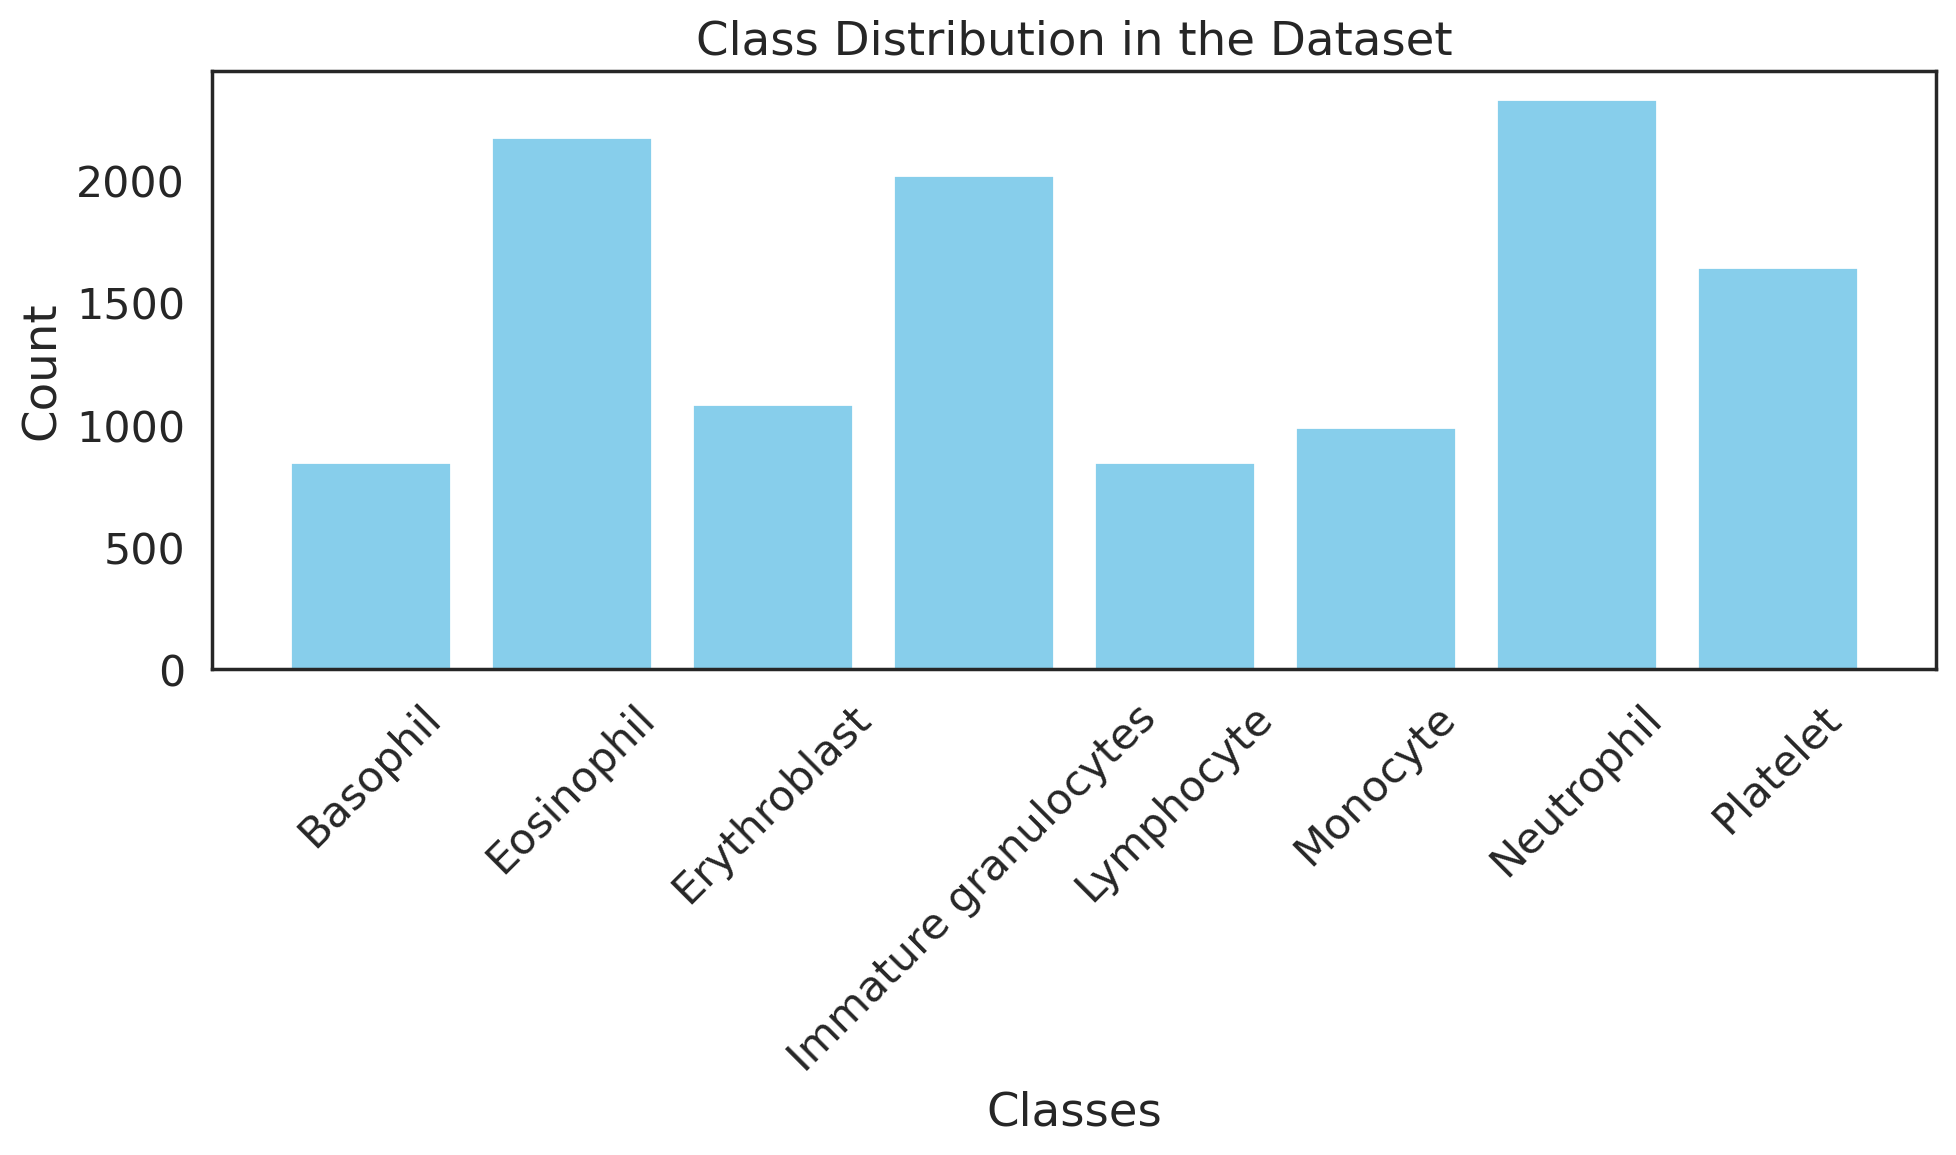

In [7]:
plot_class_distribution(y, class_labels)

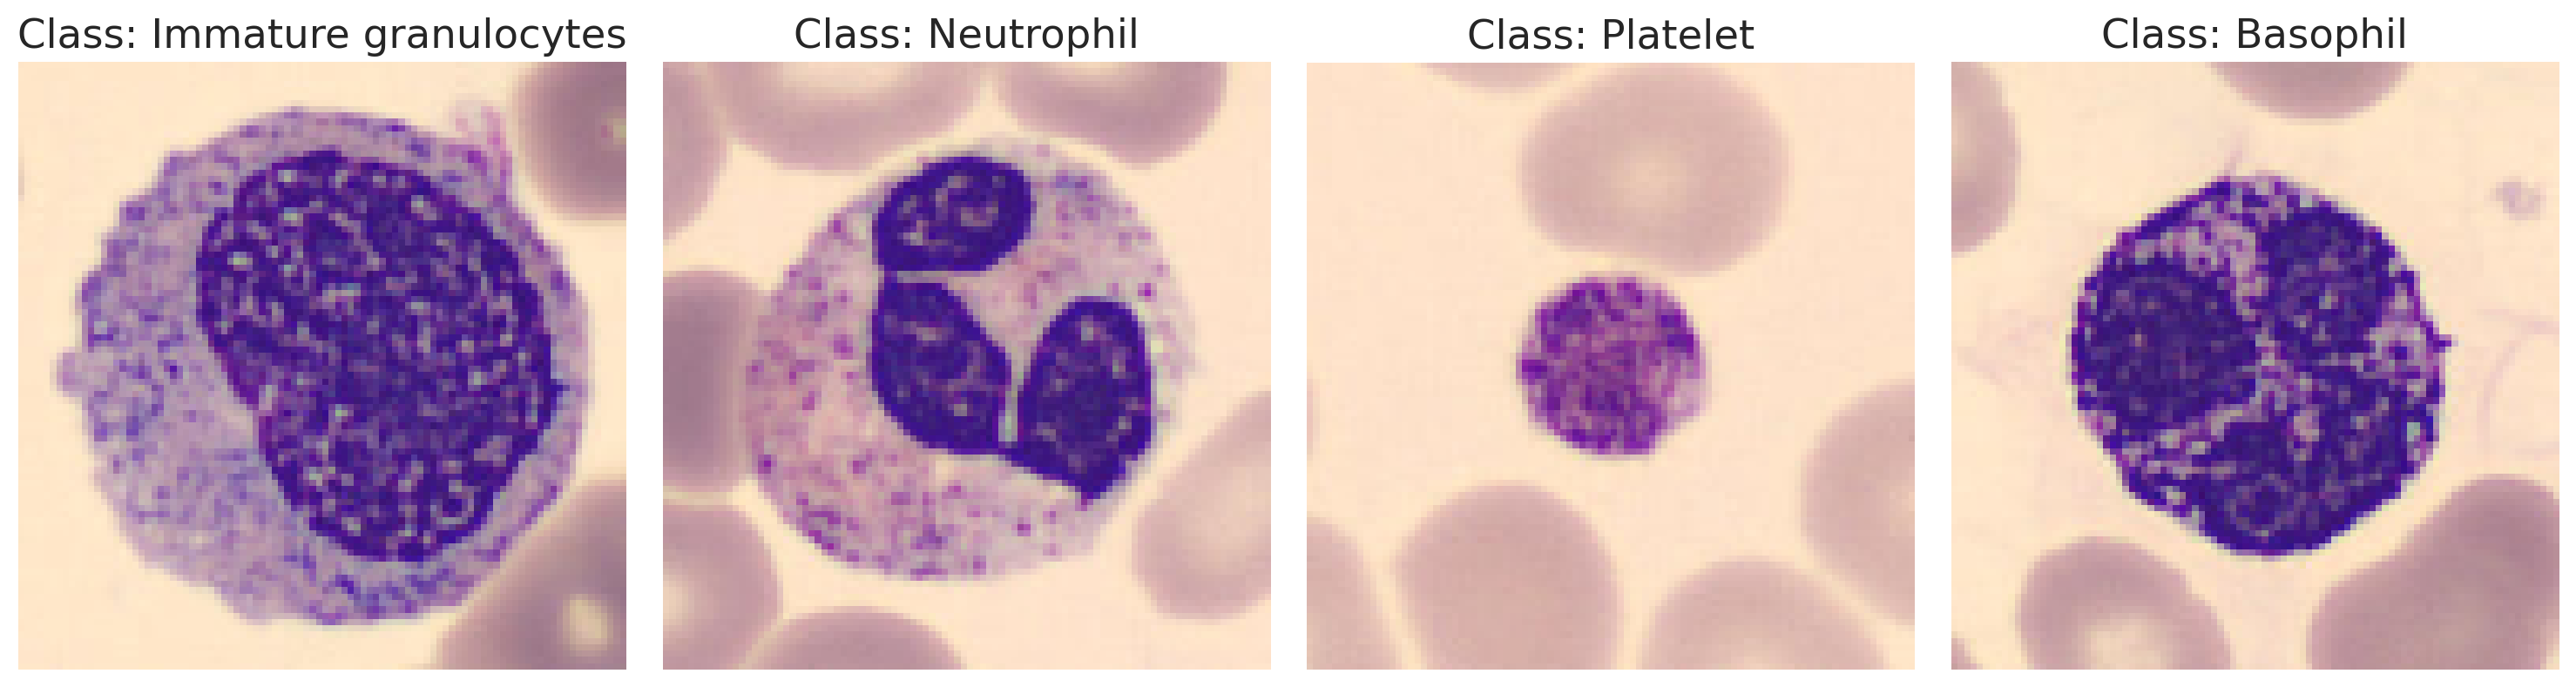

In [8]:
display_images(X, y, class_labels, [1, 5_000, 10_000, 2_500])

### Data Splitting and One-Hot Encoding

In this code snippet, the dataset is split into training and validation sets using the `train_test_split` function from the `sklearn.model_selection` module. The main points are:

1. **Dataset Splitting**:
   - The dataset `X` (images) and `y` (labels) are split into:
     - `X_train` and `y_train`: Training set for the model.
     - `X_val` and `y_val`: Validation set to evaluate model performance during training.
   - `test_size` is set as `int(X.shape[0] * 0.2)`, ensuring that 20% of the data is reserved for validation.

2. **Random Seed**:
   - The `random_state` parameter is set to a fixed seed value (`seed`) for reproducibility of results.

3. **Stratification**:
   - The `stratify` parameter ensures that the class distribution is maintained in both training and validation sets, avoiding imbalance.

4. **One-Hot Encoding**:
   - The labels are converted into one-hot encoded format using TensorFlow's `to_categorical` utility. This is necessary for classification models to properly process class labels.

5. **Display Dataset Shapes**:
   - The shapes of the resulting training and validation datasets are printed for verification.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = int(X.shape[0] * 0.2),
    random_state = seed,
    stratify = y
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print('Training set shape (images):', X_train.shape)
print('Training set shape (labels):', y_train.shape)
print('Val set shape (images):', X_val.shape)
print('Val set shape (labels):', y_val.shape)

Training set shape (images): (9555, 96, 96, 3)
Training set shape (labels): (9555, 8)
Val set shape (images): (2388, 96, 96, 3)
Val set shape (labels): (2388, 8)


### Model Training Callbacks

### Callbacks
1. **EarlyStopping**:
   - **Monitors**: Tracks a specified metric, in this case, validation accuracy.
   - **Mode**: Determines whether to maximize or minimize the monitored metric.
   - **Patience**: Number of epochs without improvement before stopping.
   - **Restore best weights**: Ensures the model's weights are set to the state of highest monitored performance.

2. **ReduceLROnPlateau**:
   - **Monitors**: Observes a specified metric, in this case, validation accuracy
   - **Mode**: Adjusts behavior based on whether the goal is to increase or decrease the metric.
   - **Minimum delta**: Defines the smallest improvement to consider progress.
   - **Patience**: Waits a specified number of epochs before reducing the learning rate.
   - **Factor**: Determines the rate of reduction for the learning rate.
   - **Minimum learning rate**: Sets a lower bound for the learning rate.

These callbacks enhance training by preventing overfitting and optimizing learning rate adjustments.


In [10]:
input_shape = (96, 96, 3)
batch_size = 32
epochs = 1000
num_classes = class_count

early_stopper = tfk.callbacks.EarlyStopping (
    monitor = 'val_accuracy',
    mode = 'max',
    patience = 3,
    restore_best_weights = True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau (
    monitor = 'val_accuracy',
    mode = 'max',
    min_delta = 0.01,
    patience = 3,
    factor = 0.5,
    verbose = 1,
    cooldown = 0,
    min_lr = 0.000001
)

## Augmentation Layers

1. **`RandAugment`**:
   - Randomly applies a set of augmentations to each image.
   - **Parameters**:
     - `value_range=(0, 1)`: Input pixel values are expected to be normalized between 0 and 1.
     - `augmentations_per_image=3`: Number of random augmentations applied to each image.
     - `magnitude=0.1`: Controls the intensity of the augmentations.

2. **`GaussianNoise`**:
   - Adds random noise to the input images, simulating real-world noise.
   - **Parameters**:
     - `stddev=0.05`: Standard deviation of the Gaussian noise.

3. **`AugMix`**:
   - Applies chained transformations and mixes them to create augmented images.
   - **Parameters**:
     - `value_range=(0, 1)`: Input pixel values are normalized between 0 and 1.
     - `severity=0.1`: Controls the intensity of each transformation.
     - `num_chains=3`: Number of parallel augmentation chains.
     - `chain_depth=(1, 3)`: Number of transformations per chain (range: 1 to 3).
     - `alpha=1.0`: Controls the blending of the original image and augmentations.

4. **`MixUp`**:
   - Combines two images and their labels in a weighted manner, simulating new data points.
   - **Parameters**:
     - `alpha=0.2`: Controls the beta distribution for blending images and labels.

In [11]:
rand_augment = keras_cv.layers.RandAugment(
    value_range = (0, 1), augmentations_per_image = 3, magnitude = 0.1
)

In [12]:
gaussian_layer = tfk.layers.GaussianNoise(stddev = 0.05)

In [13]:
augmix_layer = keras_cv.layers.AugMix(
    value_range = (0, 1),
    severity = 0.1,
    num_chains = 3,
    chain_depth = (1, 3),
    alpha = 1.0
)

In [14]:
mixup = keras_cv.layers.MixUp(alpha = 0.2)

In [15]:
# Define preprocessing function
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0

    image = augmix_layer(image)
    image = rand_augment(image)
    image = gaussian_layer(image, training = True)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [16]:
# Prepare tf.data.Dataset with AugMix preprocessing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
def preprocess_image_mixup(image, label):
    return mixup({"images": image, "labels": label})

train_dataset_mixup = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset_mixup = train_dataset_mixup.shuffle(buffer_size = 1024).batch(batch_size)
train_dataset_mixup = train_dataset_mixup.map(preprocess_image_mixup, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset_mixup = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [18]:
def show_random_mixup_images(dataset, num_images=20):
    """
    function to display a random sample of images from the dataset.
    """
    plt.figure(figsize=(20, 20), dpi = 200)
    selected_images = []

    # Collect images and labels from the dataset
    for sample in dataset.unbatch():
        image = sample["images"].numpy()
        label = sample["labels"].numpy()

        selected_images.append((image, label))
        if len(selected_images) >= num_images:
            break

    # Shuffle the selected images randomly
    np.random.shuffle(selected_images)

    # Display the images in a grid
    cols = min(num_images, 5)
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(num_images):
        image, label = selected_images[i]

        # Decode labels into human-readable format
        titles = [f'{class_labels[idx]}: {round(prob, 3)}' for idx, prob in enumerate(label) if prob > 0]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title('\n'.join(titles), fontsize = 9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
def display_original_and_augmented(X_train, train_dataset, num_images=6):
    original_images = X_train[:num_images]

    augmented_images = []
    for img_batch, _ in train_dataset.unbatch().take(num_images):
        augmented_images.append(img_batch.numpy())
    augmented_images = np.array(augmented_images)

    plt.figure(figsize=(12, 6), dpi = 200)
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray', vmin=0, vmax=255)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Augmented")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

<Figure size 4000x4000 with 0 Axes>

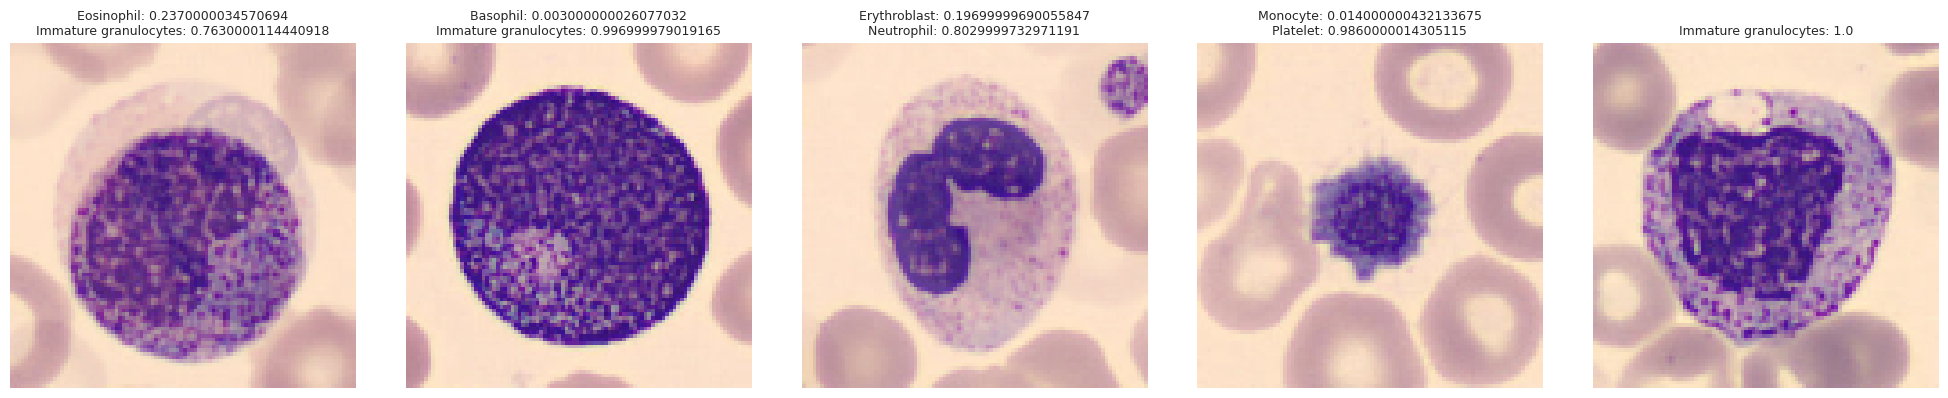

In [20]:
show_random_mixup_images(train_dataset_mixup, 5)

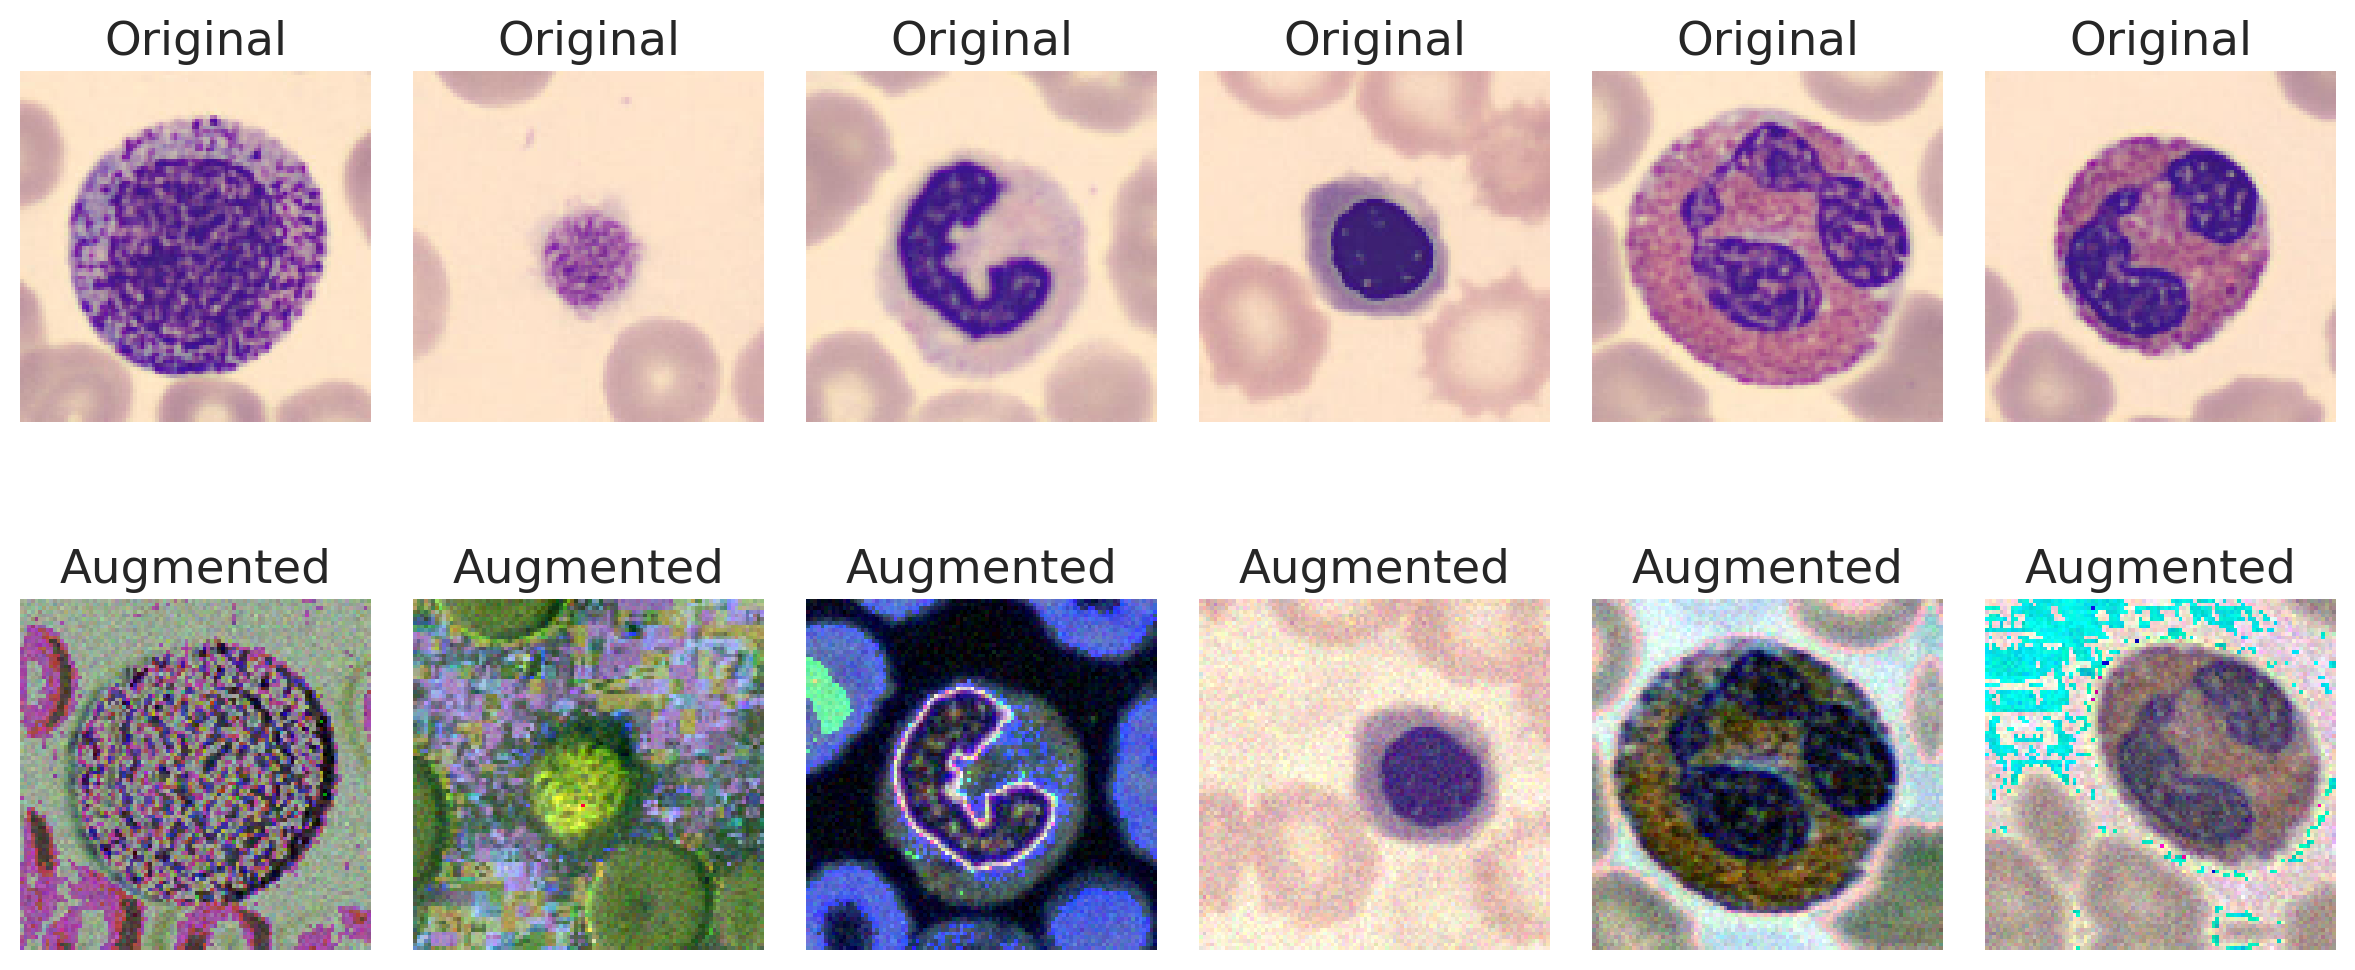

In [21]:
display_original_and_augmented(X_train, train_dataset, num_images=6)

##TRANSFER LEARNING

1. **Compute Class Weights**:
   - Uses `compute_class_weight` to calculate weights for each class based on their frequency in the training data.
   - Converts the weights into a dictionary (`class_weight_dict`) for use during model training.

2. **Initialize Base Model**:
   - Loads the MobileNetV3Small architecture pre-trained on ImageNet.
   - Removes the top classification layer (`include_top=False`) for transfer learning.
   - Configures `pooling='avg'` to reduce spatial dimensions via global average pooling.
   - Includes preprocessing specific to MobileNetV3 (`include_preprocessing=True`).


In [22]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes = labels,
    y = np.argmax(y_train, axis = 1)
)

class_weight_dict = dict(enumerate(class_weights))

base_model = tfk.applications.MobileNetV3Small(
    input_shape = input_shape,
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
    include_preprocessing = True
)

model_name = base_model.__class__.__name__

1. **Freeze the Pre-trained Base**:
   - `base_model.trainable = False` ensures that the pre-trained weights of MobileNetV3Small are not updated during training, preserving its feature extraction capabilities.

2. **Input Layer**:
   - `tfk.Input(shape=input_shape, name='input_layer')` defines the input shape for the model.

3. **Custom Dense Layers**:
   - Multiple fully connected layers are added on top of the pre-trained base:
     - **Dense Layer 1**: 1024 neurons, `ReLU` activation, L2 regularization, and 20% dropout.
     - **Dense Layer 2**: 512 neurons, `ReLU` activation, L2 regularization, and 20% dropout.
     - **Dense Layer 3**: 256 neurons, `ReLU` activation, L2 regularization, and 20% dropout.

4. **Output Layer**:
   - `Dense` layer with `num_classes` neurons and `softmax` activation for multi-class classification.

5. **Model Definition**:
   - Combines the input, pre-trained base, and custom layers into a complete model using `tfk.Model`.

6. **Model Compilation**:
   - Uses `CategoricalCrossentropy` as the loss function.
   - Optimizes with the `Adam` optimizer.
   - Tracks `accuracy` as a performance metric.

In [23]:
base_model.trainable = False

inputs = tfk.Input(shape=input_shape, name='input_layer')
X = base_model(inputs)

X = tfkl.Dense(1024, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01))(X)
X = tfkl.Dropout(0.2)(X)

X = tfkl.Dense(512, activation='relu', kernel_regularizer = tfk.regularizers.l2(0.01))(X)
X = tfk.layers.Dropout(0.2)(X)

X = tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01))(X)
X = tfkl.Dropout(0.2)(X)

outputs = tfkl.Dense(num_classes, activation='softmax', name='dense4')(X)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(),
    metrics=['accuracy']
)

In [24]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {len(gpus)}")
for gpu in gpus:
    print(gpu)

Available GPUs: 1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


1. **Model Training**:
   Uses the `train_dataset` and `val_dataset` to train the model (`tl_model`) over 1000 epochs with the following callbacks:
   - `early_stopper`: Stops training early if validation metrics do not improve.
   - `reduce_lr`: Reduces the learning rate when performance plateaus.

2. **Validation Accuracy**:
   Calculates the best validation accuracy achieved during training.


In [25]:
epochs = 1000

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

with tf.device('/GPU:0'):
    tl_history = tl_model.fit(
        train_dataset,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = val_dataset,
        callbacks = [early_stopper, reduce_lr]
    ).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = model_name + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

## FINE TUNING

In [26]:
model_filename = 'EfficientNetV2S_best.keras'

# Re-load the model after transfer learning
ft_model = tfk.models.load_model(model_filename)

# Display a summary of the model architecture
ft_model.summary(expand_nested = True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested = True, show_trainable = True, show_shapes = True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentations (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_4            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 1280)                │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 24)          │              

 Total params: 24,291,194 (92.66 MB)

 Trainable params: 1,319,944 (5.04 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 2,639,890 (10.07 MB)

1. **Freeze Layers**:
   - Initially, all layers in the model are frozen (`layer.trainable = False`).

2. **Enable Trainability for Selected Layers**:
   - The last `N` layers of type `Conv2D` or `DepthwiseConv2D` are unfrozen (`layer.trainable = True`).
   - This allows fine-tuning of specific convolutional layers while keeping earlier layers frozen.

3. **Compile the Model**:
   - Loss: `CategoricalCrossentropy` for multi-class classification.
   - Optimizer: Adam with a learning rate of `1e-4`.
   - Metric: `accuracy`.

4. **Train the Model**:
   - Fine-tunes the model on `train_dataset` with validation on `(X_val, y_val)`.
   - Uses callbacks like `early_stopper` and `reduce_lr` to improve training efficiency.


In [26]:
N = 128

for layer in ft_model.layers:
    layer.trainable = False

for i, layer in enumerate(ft_model.layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfk.layers.DepthwiseConv2D):
      if i > N:
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Fine-tune the model
ft_history = ft_model.fit(
    train_dataset,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [early_stopper, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

In [26]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = model_name + str(final_val_accuracy) + '.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

In [26]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()